In [2]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds
import gc

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator, DeepSpeedPlugin
import torch.nn as nn
# # SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder
from generative_models.sgm.models.diffusion import DiffusionEngine
from omegaconf import OmegaConf

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils

/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data_path="/weka/proj-fmri/shared/mindeyev2_dataset"
data_type = torch.float16
device = torch.device("cuda")

In [4]:
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'][:]
images = torch.Tensor(images).to("cpu").to(data_type)
print("Loaded all 73k possible NSD images to cpu!", images.shape)

Loaded all 73k possible NSD images to cpu! torch.Size([73000, 3, 224, 224])


In [5]:
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-bigG-14",
    version="laion2b_s39b_b160k",
    output_tokens=True,
    only_tokens=True,
)
clip_img_embedder.to(device)

FrozenOpenCLIPImageEmbedder(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 1664, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-47): 48 x ResidualAttentionBlock(
            (ln_1): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1664, out_features=1664, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1664, out_features=8192, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=8192, out_features=1664, bias=True)
            )
            (ls_2): Identity()


In [6]:
#Unclip setup
config = OmegaConf.load("generative_models/configs/unclip6.yaml")
config = OmegaConf.to_container(config, resolve=True)
unclip_params = config["model"]["params"]
network_config = unclip_params["network_config"]
denoiser_config = unclip_params["denoiser_config"]
first_stage_config = unclip_params["first_stage_config"]
conditioner_config = unclip_params["conditioner_config"]
sampler_config = unclip_params["sampler_config"]
scale_factor = unclip_params["scale_factor"]
disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]

first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
sampler_config['params']['num_steps'] = 38

diffusion_engine = DiffusionEngine(network_config=network_config,
                               denoiser_config=denoiser_config,
                               first_stage_config=first_stage_config,
                               conditioner_config=conditioner_config,
                               sampler_config=sampler_config,
                               scale_factor=scale_factor,
                               disable_first_stage_autocast=disable_first_stage_autocast)
        # set to inference
diffusion_engine.to(device)
diffusion_engine.eval().requires_grad_(False)

ckpt_path = '/weka/proj-fmri/shared/cache/sdxl_unclip/unclip6_epoch0_step110000.ckpt'
ckpt = torch.load(ckpt_path, map_location='cpu')
diffusion_engine.load_state_dict(ckpt['state_dict'])

image = images[:1].to(device)
batch={"jpg": image,
              "original_size_as_tuple": torch.ones(image.shape[0], 2).to(device) * image.shape[-1],
              "crop_coords_top_left": torch.zeros(image.shape[0], 2).to(device)}
out = diffusion_engine.conditioner(batch)
vector_suffix = out["vector"].to(device)
print("vector_suffix", vector_suffix.shape)
m = diffusion_engine.t2i_unclip()

Initialized embedder #0: FrozenOpenCLIPImageEmbedder with 1909889025 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
vector_suffix torch.Size([1, 1024])


In [7]:
from diffusers import T2IAdapter, StableDiffusionXLAdapterPipeline, DDPMScheduler
t2iadapter = T2IAdapter(
            in_channels=3,
            channels=(320, 640, 1280, 1280),
            num_res_blocks=2,
            downscale_factor=8,
            adapter_type="full_adapter_xl",
        )
class downSampleExtn(nn.Module):
    def __init__(self):
        super(downSampleExtn, self).__init__()
        self.conv2 = nn.Conv2d(in_channels=640, out_channels=640, kernel_size=3, stride=1, padding=1)
        self.downsample2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Reduce to [1, 640, 48, 48]

        self.conv3 = nn.Conv2d(in_channels=1280, out_channels=1280, kernel_size=3, stride=1, padding=1)
        self.downsample3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Reduce to [1, 1280, 24, 24]

        self.conv4 = nn.Conv2d(in_channels=1280, out_channels=1280, kernel_size=3, stride=1, padding=1)
        self.downsample4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Reduce to [1, 1280, 24, 24]

    def forward(self, x2, x3, x4):
        x2 = self.downsample2(self.conv2(x2))
        x3 = self.downsample3(self.conv3(x3))
        x4 = self.downsample4(self.conv4(x4))
        return x2, x3, x4

# Instantiate the model with specific downsampling
model_with_specific_downsampling = downSampleExtn()

In [8]:
class T2IAdapterExtn(nn.Module):
    def __init__(self, t2iadapterXL, extn):
        super(T2IAdapterExtn, self).__init__()
        self.t2iadapterXL = t2iadapterXL
        self.extn = extn

    def forward(self, x):
        ten_arr = self.t2iadapterXL(x)
        x1, x2, x3 = self.extn(ten_arr[1], ten_arr[2], ten_arr[3])
        unet_residuals = [ten_arr[0], x1, x2, x3]
        return unet_residuals


x = torch.randn(1, 3, 768, 768)
model = T2IAdapterExtn(t2iadapter, model_with_specific_downsampling)
y = model(x)
for i in y:
    i += 5000
    i = i.cuda()


In [9]:
emb = clip_img_embedder(images[1].unsqueeze(0).cuda())

In [10]:
import utils
samples = utils.unclip_recon(emb,
                             diffusion_engine,
                             vector_suffix, adapter_vectors=y)

/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [ ]:
y[1] * 50000

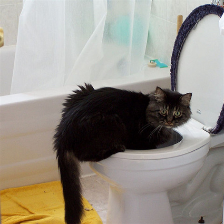

In [21]:
from torchvision import transforms
img = transforms.ToPILImage()(images[1])
img

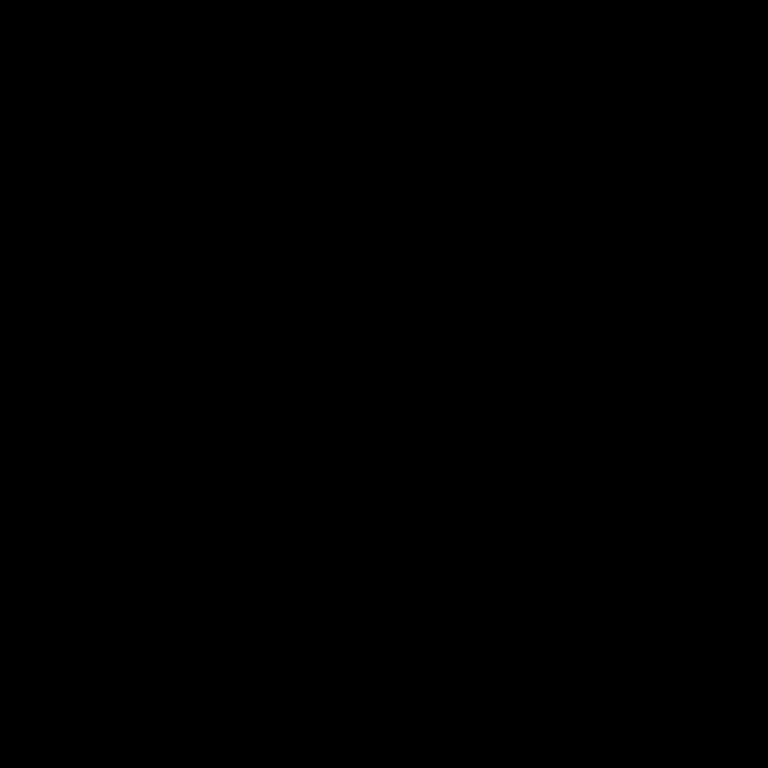

In [11]:
img_unclip = transforms.ToPILImage()(samples[0])
img_unclip

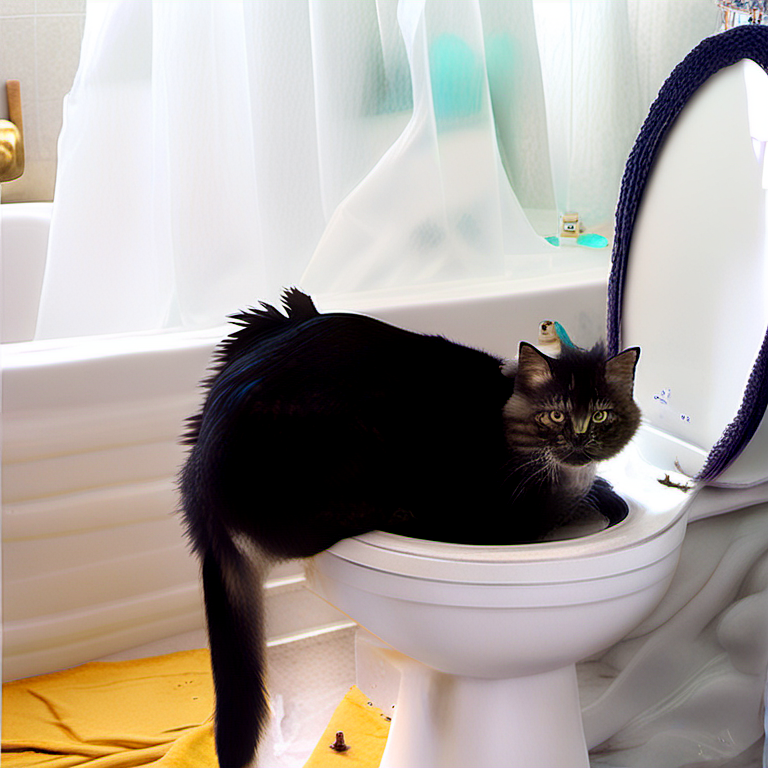

In [35]:
img_unclip = transforms.ToPILImage()(samples[0])
img_unclip

In [14]:
x = torch.randn(([2, 320, 48, 48]))
y = torch.randn(([2, 320, 16, 16]))
z = x + y

RuntimeError: The size of tensor a (48) must match the size of tensor b (16) at non-singleton dimension 3

In [15]:
diffusion_engine

DiffusionEngine(
  (model): OpenAIWrapper(
    (diffusion_model): UNetModel(
      (time_embed): Sequential(
        (0): Linear(in_features=320, out_features=1280, bias=True)
        (1): SiLU()
        (2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (label_emb): Sequential(
        (0): Sequential(
          (0): Linear(in_features=1024, out_features=1280, bias=True)
          (1): SiLU()
          (2): Linear(in_features=1280, out_features=1280, bias=True)
        )
      )
      (input_blocks): ModuleList(
        (0): TimestepEmbedSequential(
          (0): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1-2): 2 x TimestepEmbedSequential(
          (0): ResBlock(
            (in_layers): Sequential(
              (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
              (1): SiLU()
              (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (h_upd): Identity()
